In [1]:
# Setup what we need
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt

import torch
from pyzag import ode, nonlinear, chunktime

## Define the model
Our model can be defined as a system of ordinary differential equations of the form
$$ \dot{v} = h - c v$$
and
$$ \dot{z} = v $$

where $v$ is a vector of two components containing the x and y velocity of the cannonball, $z$ is a vector giving the position of the ball, $h$ is a vector defining graviational acceleration, and $c$ is a constant related to the wind resistance experienced by the ball in flight.  We can expand this vector description into explicit equations for the $x$ and $y$ components of the velocity:
$$ \begin{bmatrix}
\dot{v}_x\\ 
\dot{v}_y
\end{bmatrix}

=

\begin{bmatrix}
0 \\ 
-g
\end{bmatrix}

-

c
\begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} $$
where $g$ is now the regular scalar gravitational acceleration.

We can trivially do this for the position as well:
$$ \begin{bmatrix}
\dot{z}_x\\ 
\dot{z}_y
\end{bmatrix}

=
\begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} $$

In addition, we need initial conditions for the velocities, which we can define as:
$$ \begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} =
 \begin{bmatrix}
v_0 \cos \theta_0 \\ 
v_0 \sin \theta_0
\end{bmatrix} $$
where $\theta_0$ is the cannon launch angle and $v_0$ is the scalar launch velocity.  We will let the position of the cannon, i.e. $z = 0$.

### Rate form
In pyzag we can split the definition of the model into a couple of parts.  The first is just the mathematical definition of the ODE.  We need to define this as the full system of four ODEs, two equations each for the velocity and the position.  We'll call this full system of equations $\dot{s}$ where $s$ is a vector given by
$$ s =
\begin{bmatrix}
v_x \\ 
v_y \\
z_x \\
z_y 
\end{bmatrix} $$

In addition to implementing the rate form of the equations we defined above, we also need to define the Jacobian, given by
$$
J = \frac{d \dot{s}}{d s}
$$
and return this value, along with the actual equations, as part of the `forward` operator.  The reason we need the Jacobian is explained in the next cell.

In [2]:
# Define the rate form of the model
class CannonRateForm(torch.nn.Module):
    """ODE equations defining the canon trajectories
    """
    def __init__(self, c, g, theta0, v0):
        super().__init__()
        self.c = torch.nn.Parameter(torch.tensor(c))
        self.h = torch.tensor([0,-g])
        self.theta0 = torch.nn.Parameter(torch.tensor(theta0))
        self.v0 = torch.nn.Parameter(torch.tensor(v0))

    def forward(self, t, s):
        """Rate form and Jacobian of the model

        Args:
            t (torch.tensor): time (not actually used in this example!)
            s (torch.tensor): concatenated velocity and position vectors
        """
        v = s[...,:2]
        # Define the rate form
        v_dot = self.h - self.c * v
        s_dot = torch.cat([v_dot, v], dim = -1)
        # Define the Jacobian
        I = torch.eye(2, device = s.device).expand(v.shape + (2,))
        zero = torch.zeros_like(I)
        Jvv = - self.c *  I
        Jzv = I

        J = torch.cat([torch.cat([Jvv, zero], dim = -1), torch.cat([Jzv, zero], dim = -1)], dim = -2)

        return s_dot, J

    def y0(self, expand = None):
        """Define the model initial conditions

        Keyword Args:
            expand (shape or None): if not None expand to the indicated shape
        """
        y0 = torch.tensor([torch.cos(self.theta0), torch.sin(self.theta0), 0.0, 0.0])
        if expand:
            y0 = y0.expand(expand + y0.shape)

        return y0

We will be changing these values a lot below, but let's define the model with some reasonable values for the parameters $c$, $\theta_0$, and $v_0$ and give a value for the gravitational acceleration:

In [3]:
c = 0.1
g = 1.0
theta0 = torch.pi / 4
v0 = 1.0
rate_model = CannonRateForm(c, g, theta0, v0)

### Discrete equation
Next we need to apply a numerical time integration scheme to this ODE so that we end up with a discrete (generally) nonlinear system of equations.  We'll use the Backward Euler scheme here, which will transform the ODE into an implicit system of algebraic equations we need to solve to find the next set of velocities, as we march through the trajectory in time.  Specifically, the Backward Euler scheme will give us the equations:
$$
0 = v_{n+1} - v_n - \dot{v}_{n+1} \Delta t_{n+1}
$$
where $n+1$ means the next time step, $n$ means the previous time step, $\dot{v}{n+1}$ means we have to evaluate the change in velocity using the velocities for the *next* step, making this an implicit equation, and $\Delta t_{n+1}$ is the change in time from step $n$ to $n+1$.

Luckily you don't need to do anything here as pyzag comes with predefined models for applying numerical time integration.

In [4]:
discrete_model = ode.BackwardEulerODE(rate_model)

### Solving the model
Finally we need to define an object that will actually numerically solve our discrete equations.  The inputs to this function will be the times at which we want solutions, the output will be the actual cannonball trajectories.  This is often on you, the user, to define because you might want to do some postprocessing before you pass back the series of results.  In our example the only postprocessing we'll do is to return only the cannonball trajectories and not the velocity.

To solve the discrete equations we'll use the `RecursiveNonlinearEquationSolver` class provided in the `pyzag.nonlinear` module.  This object solves for the discrete trajectories in a way that allows us to vectorize some of the time integration cost by looking to integrate `nchunk` time steps at once.  Additionally, this object takes other numerical hyperparameters related to how to numerically solve for the trajectories.  One of these (the absolute convergence tolerance) we adjust here.  The others the default values are fine

In [5]:
class Trajectory(torch.nn.Module):
    def __init__(self, discrete_equations, nchunk = 1):
        super().__init__()

        self.discrete_equations = discrete_equations
        self.solver = nonlinear.RecursiveNonlinearEquationSolver(self.discrete_equations, step_generator = nonlinear.StepGenerator(nchunk), nonlinear_solver=chunktime.ChunkNewtonRaphson(atol = 1e-3, rtol = 1e-5))

    def forward(self, t):
        n = len(t)

        full_trajectory = nonlinear.solve_adjoint(
            self.solver, self.discrete_equations.ode.y0(t.shape[1:-1]), n, t
        )

        return full_trajectory[...,2:]

In [6]:
nchunk = 10 # Best value will depend on your system
model = Trajectory(discrete_model, nchunk = nchunk)

## Simulating trajectories
Alright, let's simulate some trajectories.  Right now things are boring and all we can do is run a single trajectory.  But let's see what that looks like.

We have a couple more parameters to define, the time to consider and the number of time steps.

In [17]:
stop_time = 1.0
ntime = 100

Text(0, 0.5, 'y')

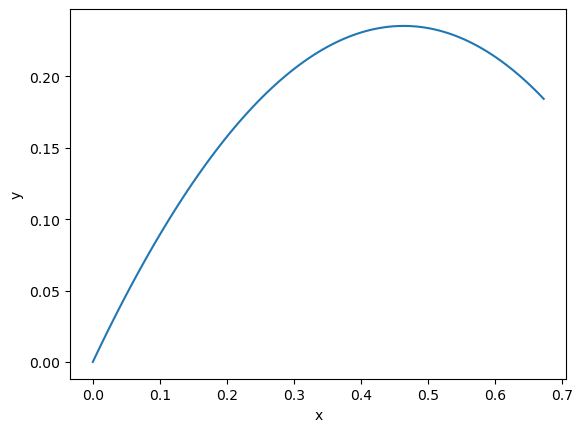

In [19]:
# The unsqueeze here are for two reasons:
# 1) We've decided that even scalar inputs need to have a shape of (1,)
# 2) Our batch shape is (1,)
# So the shape of times should be (ntime,1,1)
times = torch.linspace(0, stop_time, ntime).unsqueeze(-1).unsqueeze(-1)
# Run the model
first_result = model(times)
plt.plot(first_result[:, 0, 0].detach(), first_result[:, 0, 1].detach())
plt.xlabel("x")
plt.ylabel("y")